In [1]:

!pip install torch torchvision matplotlib

import tensorflow as tf
from torchvision import models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset
import matplotlib.pyplot as plt



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\03tho\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Dataset loaded.
Labels in the batch: tensor([0, 0, 9, 5, 3, 7, 5, 2, 7, 9, 7, 4, 7, 1, 7, 9, 0, 5, 2, 8, 6, 8, 6, 6,
        5, 5, 6, 8, 9, 7, 2, 4])
Labels in the batch_resnet: tensor([6, 3, 9, 5, 0, 5, 9, 8, 5, 4, 0, 7, 7, 6, 5, 3, 1, 1, 5, 1, 3, 2, 5, 8,
        8, 7, 4, 5, 7, 5, 4, 1])


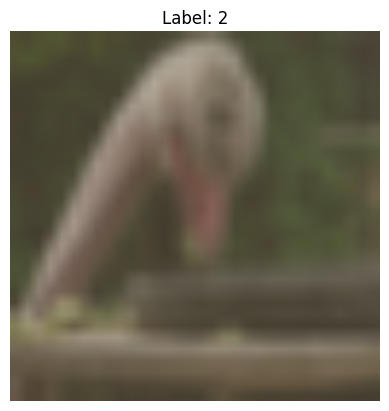

Number of samples: 50000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 299x299 pixels, needed for Inception V3
    transforms.ToTensor(),  # Convertin images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusting pixel values to between -1 and 1
])

#This is for resnet. Resnet performs better with 244x244 rather than the bigger image size. 
resnet_transform = transforms.Compose([
    transforms.Resize(256),  # Resize the smaller side to 256, maintaining aspect ratio
    transforms.CenterCrop(224),  # Crop the center to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
#Could be bias here if the images have something that is on the outside of the image as we are reducing size here. 
train_dataset_resnet = CIFAR10(root='./data', train=True, download=True, transform=resnet_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#Batch size of 32 means less memory used compared to other values. Too high its too general. Too low u may develop a bias due to learning at very regular rates. 
print("Dataset loaded.")
for images, labels in train_loader:
    print("Labels in the batch:", labels)
    break

for images, labels in train_loader_resnet:
    print("Labels in the batch_resnet:", labels)
    break
# Show an image from the CIFAR-10 dataset
def show_example(dataset):
    # Get an example image and its label
    img, label = dataset[400]  # Change the index to see a different example. This one is an ostrich. 
    
    # Convert tensor to numpy for visualization
    img = img.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

    # Denormalize the image (if you normalized during preprocessing)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Undo normalization
    img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1 for display

    # Show the image
    plt.imshow(img)
    plt.title(f"Label: {label}")  # Display the label
    plt.axis("off")
    plt.show()
    
    print("Number of samples:", len(train_dataset))
    print("Classes:", train_dataset.classes)  # Class names (e.g., 'airplane', 'automobile', etc.)



# Show Example
show_example(train_dataset)



In [20]:
#Setup for kfold validation. 
k=5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Load pre-trained Inception V3 moel

inception = models.inception_v3(weights='DEFAULT')
inception.fc = nn.Linear(2048, 10)  # Adjust final layer for 10 classes
print("Offload the work to the gpu ha")
##inception = inception.cuda()
    
inception.aux_logits = False  # Disable auxiliary classifier to prevent errors during training
print("Loading InceptionV3 model")

print("Models loaded and customized for CIFAR-10.")


# Load Pre-Trained ResNet50

resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
    
#resnet = resnet.cuda()

resnet.fc = nn.Linear(2048, 10)  # Adjust final layer for 10 classes
    
print("Loading ResNet50")
print("Models loaded and customized for CIFAR-10.")




C:\Users\03tho\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\03tho\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Offload the work to the gpu ha
Loading InceptionV3 model
Models loaded and customized for CIFAR-10.


C:\Users\03tho\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading ResNet50
Models loaded and customized for CIFAR-10.


In [22]:
def train(model, loader, criterion, optimizer, epochs=1):
    model.train()  # Set the model to training mode

    for epoch in range(epochs):  # Loop over the specified number of epochs
        running_loss = 0.0  # Initialize a variable to accumulate the loss for the current epoch

        for inputs, labels in loader:
            #inputs, labels = inputs.cuda(), labels.cuda()  # Move inputs and labels to the GPU

            # Zero the parameter gradients to avoid accumulation from previous steps
            optimizer.zero_grad()

            # Forward pass: compute model predictions
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backward pass: compute gradients
            loss.backward()

            # Update model parameters using the computed gradients
            optimizer.step()

            # Print the average loss for the current epoch
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(loader)}")

def evaluate(model, loader):
    model.eval()  # Set the model to evaluation mode

    #Initialize counters
    correct = 0
    total = 0

    with torch.no_grad():  # No need for backpropagate in eval
        for inputs, labels in loader:
           # inputs, labels = inputs.cuda(), labels.cuda()

            # Forward pass
            outputs = model(inputs)

            # Get the predicted class by taking the index of the maximum output (i.e., the predicted class)
            _, predicted = torch.max(outputs.data, 1)

            # Update counters for total labels and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy as the percentage of correct predictions
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

    return accuracy


K Fold Cross-Validation

In [ ]:
#Initialise fold_accuracies
fold_accuracies = []

# Loop through folds
for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)))):
    print(f"Fold {fold+1}/{k}")
    
    # Train and val subset being defined. 
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    
    # Initialising my loaders with a batch size of 32
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    # Loading the pre-trained model
    model = models.resnet50(pretrained=True)  # Using resnet
    model.fc = nn.Linear(model.fc.in_features, 10)  # Modify for your dataset
    model = model.to(device)
    history = model.fit(train_loader, val_loader)
    # Define loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    accuracy = train(model, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=10)
    fold_accuracies.append(accuracy)

# Average accuracy
print(f"Average Accuracy: {sum(fold_accuracies) / len(fold_accuracies):.4f}")



Training and Evaluation
Inception V3

NameError: name 'inception' is not defined

In [23]:
#This block will train and evaluate V3
# Set the loss function.

optimizer_inception = optim.Adam(inception.parameters(), lr=0.001)
# Uses Adam optimizer for efficiency. adjusts LR based on graients to aid fast convergence.

print("Training Inception V3...")

train(inception, train_loader, nn.CrossEntropyLoss(), optimizer_inception, epochs=1)
# Call our train function to train the Inception V3 model using the CIFAR-10 training data.

print("Evaluating Inception V3...")

evaluate(inception, test_loader)
# Call our evaluate function to test the trained Inception V3 model on the CIFAR-10 test data.


Training Inception V3...



KeyboardInterrupt



In [ ]:
#This cell will train and evaluate ResNet50
optimizer_resnet = optim.Adam(resnet.parameters(), lr=0.001)

print("Training ResNet50...")

train(resnet, train_loader, nn.CrossEntropyLoss(), optimizer_resnet, epochs=1)
print("Evaluating ResNet50...")

evaluate(resnet, test_loader)

Training ResNet50...
Epoch 1, Loss: 1.1048722521128445
Evaluating ResNet50...
Accuracy: 65.25%


65.25

In [25]:
import time

# Measure Inference Time
def measure_inference_time(model, loader):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.cuda()
            _ = model(inputs)
    print(f"Inference time: {time.time() - start_time:.2f} seconds")

print("Inception V3 Inference Time:")
#measure_inference_time(inception, test_loader)

print("ResNet50 Inference Time:")
#measure_inference_time(resnet, test_loader)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example: Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="viridis")
plt.title("Confusion Matrix")
plt.show()



Inception V3 Inference Time:
ResNet50 Inference Time:


NameError: name 'true_labels' is not defined